# Figure 4A-B
Compare Omnipose to Cellpose on bacterial dataset

In [1]:
%load_ext autoreload
%autoreload 2

basedir = '/home/kcutler/DataDrive/omnipose_test'
from pathlib import Path
from cellpose import plot, models, io, dynamics
from cellpose.omnipose import utils
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import time, os, sys


2021-11-16 18:11:33,403 [INFO] WRITING LOG OUTPUT TO /home/kcutler/.cellpose/run.log


## Load ground truth

In [2]:
mask_filter = '_masks'
img_names = io.get_image_files(basedir,mask_filter,look_one_level_down=True)
mask_names,flow_names = io.get_label_files(img_names, mask_filter)
imgs = [skimage.io.imread(f) for f in img_names]
masks_gt = [skimage.io.imread(f) for f in mask_names]
# flows_gt = [skimage.io.imread(f) for f in flow_names]

Not all flows are present. Run flow generation again.


In [3]:
# count masks
cnt = 0;
for mask in masks_gt:
    lbls = np.unique(utils.format_labels(mask))
    cnt += len(lbls[lbls>0])
print(cnt)

19083


## Initialize models

In [4]:
from cellpose import core, models

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

model = [models.CellposeModel(gpu=use_GPU, model_type='bact'),
         models.CellposeModel(gpu=use_GPU, model_type='bact_omni')]

chans = [0,0] 

2021-11-16 18:11:38,750 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2021-11-16 18:11:38,751 [INFO] >>bact<< model set to be used
2021-11-16 18:11:38,752 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 18:11:38,753 [INFO] >>>> using GPU
2021-11-16 18:11:40,075 [INFO] >>bact_omni<< model set to be used
2021-11-16 18:11:40,076 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 18:11:40,090 [INFO] >>>> using GPU


In [5]:
names = ['Cellpose','Mixed','Omnipose']

In [6]:
imglist = imgs[:]
n = len(names)
N = len(imgs)
masks,flows,styles,d = [[]]*n,[[]]*n,[[]]*n,[[]]*n

## Run models

In [7]:
clean = False
if clean:
    # Cellpose 'bact', no omni reconstruction 
    masks[0], flows[0], styles[0] = model[0].eval(imglist,channels=chans,rescale=None,dist_threshold=-1,flow_threshold=0,omni=False,resample=False,tile=False, transparency=True)
    # Cellpose + omni ('Hybrid')
    masks[1], flows[1], styles[1] = model[0].eval(imglist,channels=chans,rescale=None,dist_threshold=-1,flow_threshold=0,omni=True,resample=False,tile=False,cluster=True,transparency=True)
    #Omnipose
    masks[2], flows[2], styles[2] = model[1].eval(imglist,channels=chans,rescale=None,dist_threshold=-1,flow_threshold=0,omni=True,resample=False,tile=False,cluster=True,transparency=True)

In [8]:
basedir = '/home/kcutler/DataDrive/omnipose_paper/Comparison_Examples_Final/'
if clean:
    for j in range(n):
        savedir = basedir+names[j]
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        io.save_masks(imgs, masks[j], flows[j], img_names,save_flows=True,save_outlines=True,savedir=savedir,in_folders=True,save_txt=False)

## Read in results
This step also will also delete small masks from image boundaries. 

In [9]:
import os
from cellpose.omnipose import utils 

for j in range(n):
    savedir = basedir+names[j]
    mask_names = [os.path.join(savedir+'/masks',os.path.splitext(os.path.basename(name))[0]+'_cp_masks.png') for name in img_names]
    flow_names = [os.path.join(savedir+'/flows',os.path.splitext(os.path.basename(name))[0]+'_flows.png') for name in img_names]
    masks[j] = [utils.format_labels(utils.clean_boundary(skimage.io.imread(f))) for f in mask_names]
    flows[j] = [skimage.io.imread(f) for f in flow_names]

In [10]:
from cellpose import metrics
from skimage import measure
threshold=np.linspace(0.5,1,100)
import fastremap

In [11]:
#Note that 'ap' is called average precision in cellpose, but really it is the jaccard index
ap = [[]] * len(masks) 
tp = [[]] * len(masks)
fp = [[]] * len(masks)
fn = [[]] * len(masks)
IoU = [[]] * len(masks)
OvR = [[]] * len(masks)
pred_areas = [[]] * len(masks)

In [12]:
# Do the same boundary cleaning on ground truth masks 

nimg = len(masks_gt)
cell_areas = [[]] * nimg
masks_gt_clean = [None]*nimg
masks_pred_clean = [[None]*nimg]*len(masks)
# remapping = [[]] * nimg
for j in range(nimg):
    mgt = utils.format_labels(utils.clean_boundary(masks_gt[j]))
    masks_gt_clean[j] = mgt
    regions = measure.regionprops(mgt)
    areas = np.array([reg.area for reg in regions])
    cell_areas[j] =  areas

## Compute performance metrics for each model

In [13]:
# go over each model
if clean:
    for j,masks_pred in enumerate(masks):
    #     masks_pred = map(list,zip(*[ utils.format_labels(utils.clean_boundary(msk)) for msk in masks_pred]))
    # just apply cleanup to the masks when reading them in 
        api,tpi,fpi,fni = metrics.average_precision(masks_gt_clean,masks_pred,threshold=threshold)
        ap[j] = ap[j]+[api]
        tp[j] = tp[j]+[tpi]
        fp[j] = fp[j]+[fpi]
        fn[j] = fn[j]+[fni]

        masks_pred_clean[j] = masks_pred
        # go over every image
        for k in range(nimg):
            # get the IoU matrix; axis 0 corresponds to GT, axis 1 to pred 
            regions = measure.regionprops(masks_pred[k])
            areas = np.array([reg.area for reg in regions])
            pred_areas[j] = pred_areas[j] + [areas]
            iou = metrics._intersection_over_union(masks_gt_clean[k], masks_pred[k])
            ovp = metrics._label_overlap(masks_gt_clean[k], masks_pred[k])[1:,1:] #throw out columns corresponding to zero  
            OvR[j] = OvR[j]+[ovp / areas[np.newaxis,:]] # Overlap Ratio           
            IoU[j] = IoU[j]+[iou]
 

In [14]:
savedir = '/home/kcutler/DataDrive/omnipose_paper/Comparison_Examples_Final/'

In [15]:
if clean:
    np.savez(savedir+'OvR',OvR)
    np.savez(savedir+'IoU',IoU)
    np.savez(savedir+'cell_areas',cell_areas,dtype=object)
    np.savez(savedir+'ap',ap)
# np.savez(savedir+'remapping',remapping)

## Read back in performance metics

In [16]:
OvR = np.load(savedir+'OvR'+'.npz',allow_pickle=True)['arr_0']
IoU = np.load(savedir+'IoU'+'.npz',allow_pickle=True)['arr_0']
cell_areas = np.load(savedir+'cell_areas'+'.npz',allow_pickle=True)['arr_0']
ap = np.load(savedir+'ap'+'.npz',allow_pickle=True)['arr_0']

## Calculate errors 

In [17]:
N = len(names)
nimg = len(cell_areas)
cell_errors = [[]]*N
total_errors = [0]*N
total_single_errors = [0]*N
total_cells = len(np.concatenate(cell_areas))

# area_thresh = np.linspace(1,np.max(np.concatenate(cell_areas)),100)
# area thresholds 
area_thresh = [np.percentile(np.concatenate(cell_areas),i) for i in range(100)]
M = len(area_thresh)
percent = [0]*N


for j in range(N):
    print(names[j])
    ce_thresh = [[]*2]*M
    te_thresh = np.zeros((2,M))
    tse_thresh = np.zeros((2,M))
    tc_thresh = np.zeros((2,M))
    
    for k in range(nimg):
        r = OvR[j][k].copy() #overlap ratio 
        r[r<=0.75] = 0 
        mx = np.max(r,axis=0) #find the maximum overlap for each true cell 
        mx[mx==0] = np.nan #exclude case where a spurious label has no overlaps
        hits = np.sum(r==mx,axis=1) # sum will be zero if a cell label has zero hits, not sure which ones these are
        cell_errors[j] = cell_errors[j] + [np.abs(hits-1)] #error if >1 or =0 
        total_errors[j] += np.sum(hits[hits>1]-1)+np.sum(hits==0) # -1 because a hit of 2 is 2 pred labels, 1 'extra' = 1 error
        total_single_errors[j] += np.sum(hits>1)+np.sum(hits==0)
        
        ca = cell_areas[k]
        for i,a in enumerate(area_thresh):
           
            for l in range(2): # look at both above AND below the area threshold
                cell_filter = ca>=a if l==0 else ca<a
                cell_count = np.count_nonzero(cell_filter)
                hits_thresh = hits[cell_filter] # sum will be zero if a cell label has zero hits, not sure which ones these are
#                 ce_thresh[l,i] += [np.abs(hits_thresh-1)] #error if >1 or =0 
                te_thresh[l,i] += np.sum(hits_thresh[hits_thresh>1]-1)+np.sum(hits_thresh==0) # -1 because a hit of 2 is 2 pred labels, 1 'extra' or 1 error
                tse_thresh[l,i] += np.sum(hits_thresh>1)+np.sum(hits_thresh==0)
                tc_thresh[l,i] += cell_count

    
    percent[j] = [[tse_thresh[l,i]/tc_thresh[l,i]*100 for i in range(M)] for l in range(2)]
        
    
    print('overall percentage of cells with at least one error:',total_single_errors[j]/total_cells *100)
#     print('percentage of cells with at least one error above cutoff:', tse_thresh[j]/tc_thresh *100)

Cellpose


/tmp/ipykernel_715691/3669123077.py:45: RuntimeWarning: invalid value encountered in double_scalars
  percent[j] = [[tse_thresh[l,i]/tc_thresh[l,i]*100 for i in range(M)] for l in range(2)]


overall percentage of cells with at least one error: 10.308087965149845
Mixed
overall percentage of cells with at least one error: 9.1324200913242
Omnipose
overall percentage of cells with at least one error: 3.6792106229990025


In [18]:
# print out the percent of cells with at least one error in the top quartile 
k = 75
for j in range(N):
    print(names[j],percent[j][0][k])

Cellpose 17.739568043615016
Mixed 9.540784231495072
Omnipose 4.151813797441812


## Plot Figure 4A
(Calculated above)

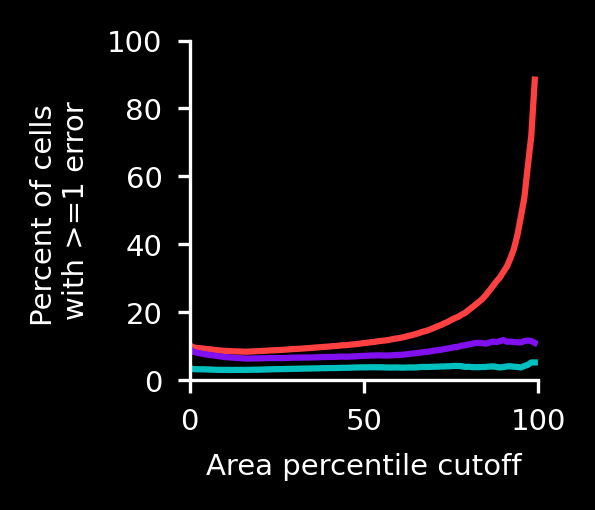

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
axcol = 'k'
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

from cellpose.omnipose.utils import sinebow
n = len(names)
z = 1
master_color_scheme = [[i,0,0] for i in np.linspace(1,.5,z)]+[[i,i,i] for i in np.linspace(.75,0,n-z)]

golden = (1 + 5 ** 0.5) / 2
sz = 1.5
labelsize = 7

%matplotlib inline
darkmode = 1
if darkmode:
    plt.style.use('dark_background')
    axcol = 'w'
    colors = sinebow(n+1)
    colors = [colors[j+1] for j in range(n)]
    background_color = 'k'
    suffix = '_dark'
else:
    mpl.rcParams.update(mpl.rcParamsDefault)
    axcol = 'k'
    cmap = mpl.cm.get_cmap('viridis')
#     colors = cmap(np.linspace(0,.9,len(names)))
    colors = master_color_scheme
    background_color = np.array([1,1,1,1])
    suffix = ''
    
mpl.rcParams['figure.dpi'] = 300

# could turn these results into a plot by repeating at different cutoffs 
fig = plt.figure(figsize=(sz, sz)) 
ax = plt.axes()
# for j in range(n):
# for j in [-1,-2]:
for j in [0,1,-1]:
#     ax.plot(area_thresh,np.divide(tse_thresh[j],tc_thresh),label=names[j],color=colors[j])
#     ax.plot(range(100),percent[j],label=names[j],color=colors[j])
    ax.plot(range(100),percent[j][0],label=names[j],color=colors[j])
#     ax.plot(range(100),percent[j][1],'--',label='above',color=colors[j])
#     print('mean percent error is',np.mean(percent[j]))
    # ax.set_facecolor('w')
# plt.xscale('log')
# ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.05, 1))

# ax.legend(prop={'size': labelsize}, loc='best', frameon=False)
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.set_ylabel('Percent of cells \nwith >=1 error', fontsize = labelsize)
ax.set_xlabel('Area percentile cutoff', fontsize = labelsize)
plt.ylim([0,100])
plt.xlim([0,100])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)

fig.patch.set_facecolor(background_color)
plt.show()

a = 35
tight_bbox_raw = ax.get_tightbbox(fig.canvas.get_renderer())
tight_bbox_raw._points+=[[-a,-a],[a,a]]
tight_bbox = mpl.transforms.TransformedBbox(tight_bbox_raw, mpl.transforms.Affine2D().scale(1./fig.dpi))


name = '/home/kcutler/DataDrive/omnipose_paper/Figure 5/error_vs_area_percentiles'+suffix
fig.savefig(name+'.eps',bbox_inches=tight_bbox)
fig.savefig(name+'.pdf',bbox_inches=tight_bbox)
# fig.savefig(name+'.eps',pad_inches = 0.5)
# fig.savefig(name+'.png',pad_inches = 0.5)

In [20]:
# Consolidate error and cell area for plotting 
a = np.concatenate(cell_areas)

In [21]:
area_cutoff = np.percentile(a,75)
print('number of cells',len(a))
print('fraction of areas', np.count_nonzero(cell_filter)/len(a)*100)
print('75th area percentile',area_cutoff)
cell_filter = a>=area_cutoff
for j in [2,1,0]:
    e = np.concatenate(cell_errors[j]) 
    print(names[j])
    print('fraction of errors',np.sum(e[cell_filter])/np.sum(e)*100)

number of cells 19053
fraction of areas 0.4041358316275652
75th area percentile 571.0
Omnipose
fraction of errors 29.526462395543174
Mixed
fraction of errors 26.42369020501139
Cellpose
fraction of errors 83.23229336093449


## Separate into cell types for plotting statistics

In [22]:
# plt.scatter(IoU[1])
cats = ['regular morphologies','mutants and antibiotics','elongated wildtype']
subsets= [['5I_crop','PAO1_Staph','PSVB','Serratia_Ecoli','wiggins','vibrio','bthai'],
          ['Hpylori','dnaA','ftsN','murA','cex','A22','Az'],
          ['caulo','streptomyces']]
K = len(cats)
indices = [[i for i,s in enumerate(mask_names) if any(name in s for name in subsets[k])] for k in range(K)]
print('Are all images accounted for?',np.sum([len(indices[k]) for k in range(K)])==len(mask_names))
print('Image category counts:',[len(indices[k]) for k in range(K)])

Are all images accounted for? True
Image category counts: [46, 66, 6]


In [23]:
names

['Cellpose', 'Mixed', 'Omnipose']

## Calculate Jaccard Index averages 

In [24]:
from scipy.optimize import linear_sum_assignment
per_cell = 1
J = len(names)
K = len(cats)
# y = [[]*K]*J #BADDDDDDDDDD! Need to check my other results to make sure it was done correctly, https://stackoverflow.com/questions/54673821/python-how-to-initialize-a-nested-list-with-empty-values-which-i-can-append-to 
y = [ [ [] for i in range(K) ] for i in range(J) ]
for j in range(J):
    for k in range(K):
        matched_iou = []
        mean_matched_iou = []
        for ind in indices[k]:
            iou = IoU[j][ind][1:,1:]
            th = 0
            n_min = min(iou.shape[0], iou.shape[1])
            costs = -(iou >= th).astype(float) - iou / (2*n_min)
            true_ind, pred_ind = linear_sum_assignment(costs)
            miou = iou[true_ind, pred_ind]
            matched_iou.append(miou)
            mean_matched_iou.append(np.sum(miou)/max(iou.shape[0], iou.shape[1]))
            
        y[j][k] = [m for sublist in matched_iou for m in sublist] if per_cell else mean_matched_iou

## Plot Jaccard Index per image
Color-coded by cell type

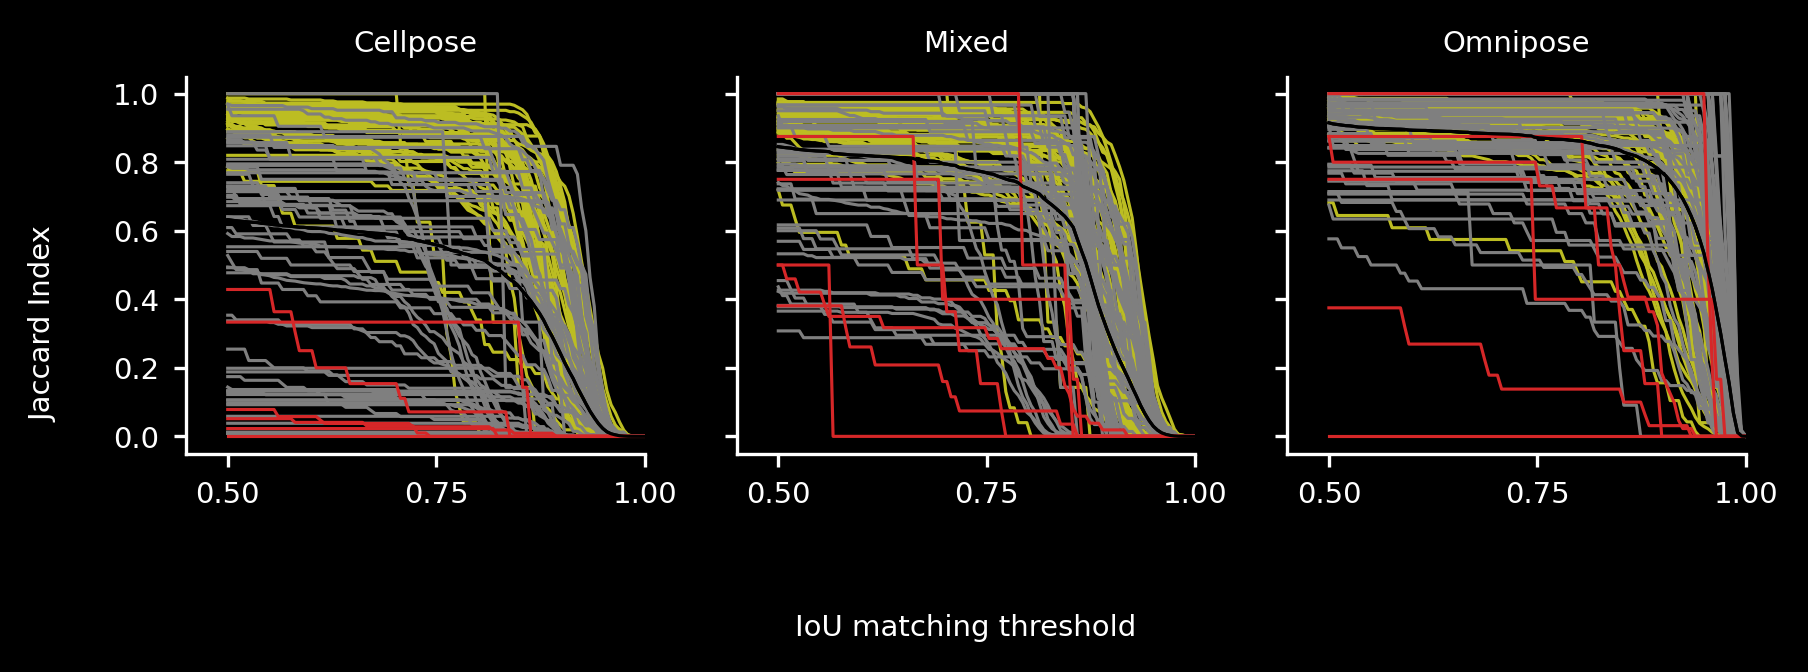

In [25]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

from cellpose.omnipose.utils import sinebow
J = len(names)
linestyle='-'
# master_color_scheme = ['r','b','g']

%matplotlib inline
darkmode = 1
if darkmode:
    plt.style.use('dark_background')
    axcol = 'w'
    colors = sinebow(J+1)
    colors = [colors[j+1] for j in range(n)]
    background_color = 'k'
else:
    mpl.rcParams.update(mpl.rcParamsDefault)
    axcol = 'k'
    cmap = mpl.cm.get_cmap('viridis')
#     colors = cmap(np.linspace(0,.9,len(names)))
#     colors = master_color_scheme
    background_color = np.array([1,1,1,1])
    
mpl.rcParams['figure.dpi'] = 300

x = threshold
golden = (1 + 5 ** 0.5) / 2
sz = 6.5
labelsize = 7
# fig = plt.figure(figsize=(sz, sz/golden)) 
# fig = plt.figure(figsize=(sz, sz/2)) 
# ax = plt.axes()
fig, axs = plt.subplots(1,len(names),figsize=(sz,sz/J),sharex=True, sharey=True)

colors = ['tab:olive','tab:gray','tab:red']
# plt.tight_layout()
# plt.minorticks_on()
plt.xticks(np.arange(min(x), max(x)+1, .25))
# plt.xlim([0.45,1.05])
# plt.ylim([0,1])
# plt.yticks(np.arange(0, 1.1, .25))

# colors = ['g','r','b','y','c','m']
# pretty_names = ['Original Cellpose','','','Mixed Method','','','','New Method']
cell_count = np.array([len(np.unique(ca)) for ca in cell_areas])
# for j in range(n):
# sort_colors = [colors[j] for j in args]
# colors = ['r',[.75,.75,.75],[0,0,0],[.5,.5,.5],[1,0,0]]

fill = 0
per_image = 1
density = 0

l = np.array([len(indices[k]) for k in range(K)])
# alpha = 1.5/(1+l/np.min(l))
alpha = [1,1,1]

from scipy.stats import gaussian_kde

for j in range(J):
    
    mean = np.mean(ap[j][0],axis=0).T
    err = np.std(ap[j][0],axis=0).T
    ax = axs[j]
    if fill:
        ax.plot(x,mean,label=names[j],color=colors[j],linestyle=linestyle)
        ax.fill_between(x,mean-err,mean+err,facecolor=colors[j],alpha=0.5)
    if per_image:
#         ax.plot(x,ap[j][0].T,label=names[j],color=colors[j],linestyle=linestyle,alpha=.05)
#         ax.plot(x,mean,label=names[j],color='k',linestyle=linestyle)
        for k in range(K):
#             if k<K-1:
#                 alpha = .25
#             else:
#                 alpha = .5
            arr =ap[j][0][indices[k]].T
            ax.plot(x,arr,label=names[j],color=colors[k],linestyle=linestyle,alpha=alpha[k],lw=.75)
            ax.plot(x,mean,label=names[j],color='k',linestyle=linestyle,lw=.75)
    if density:
        y = np.array(ap[j]).T.flatten()
        X = np.repeat(x,len(ap[j][0]))
        xy = np.vstack([X,y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        X, y, z = X[idx], y[idx], z[idx]
        ax.scatter(X, y, c=np.log(z), s=1)
    # ax.set_facecolor('w')
    # ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.05, 1))
#     ax.legend(prop={'size': 5}, loc='best', frameon=False)
    ax.set_title(names[j],fontsize=labelsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#     ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=0,left=0,labelbottom=0)

#     if j==J-1:
#         ax.set_xlabel('IoU threshold', fontsize = labelsize)
#         ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)
#         ax.tick_params(axis='x', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)

#     ax.set_ylim((0,1))
    ax.set_xlim((.5-.05,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.patch.set_alpha(0.0)

plt.subplots_adjust(bottom=.3,left=.1)
fig.patch.set_facecolor(background_color)
fig.supylabel('Jaccard Index', fontsize = labelsize)
fig.supxlabel('IoU matching threshold', fontsize = labelsize)
# swap last two 
# pos = axs[-1].get_position()
# axs[-1].set_position(axs[-2].get_position())
# axs[-2].set_position(pos)
# 
# plt.set(xlabel='IoU threshold', ylabel='Average Precision',fontsize=labelsize)
# plt.tight_layout()
# plt.yscale('log')



plt.show()

tight_bbox_raw = ax.get_tightbbox(fig.canvas.get_renderer())
a = 50
tight_bbox_raw._points+=[[-a,-a],[a,a]]
tight_bbox = mpl.transforms.TransformedBbox(tight_bbox_raw, mpl.transforms.Affine2D().scale(1./fig.dpi))

## Plot JI averaged over entire dataset, per algorithm

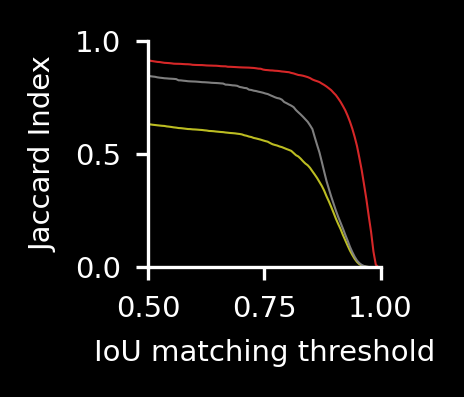

In [26]:
x = threshold
sz = 1
fig = plt.figure(figsize=(sz, sz)) 
ax = plt.axes()
# plt.tight_layout()
# plt.minorticks_on()
plt.xticks(np.arange(min(x), max(x)+1, .25))
plt.xlim([0.5,1])
plt.ylim([0,1])
# plt.yticks(np.arange(0, 1.1, .25))

# colors = ['g','r','b','y','c','m']
cell_count = np.array([len(np.unique(ca)) for ca in cell_areas])
# for j in range(n):
for j in [0,1,-1]:
    colors[j]
    ax.plot(x,np.mean(ap[j][0],axis=0).T,label=names[j],color=colors[j],linewidth=.5)
#     ax.plot(x,np.mean((fp[j][0]+fn[j][0]),axis=0),label=pretty_names[j],color=colors[j])


# ax.set_facecolor('w')
# ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.05, 1))
# ax.legend(prop={'size': labelsize}, loc='best', frameon=False)
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
# plt.setp(ax.xaxis.get_label(), visible=True, text='IoU')
# plt.setp(ax.get_xticklabels(), visible=True, ha='right')

# ax.grid(b=True, which='major', color='b', linestyle='-')
ax.set_ylabel('Jaccard Index', fontsize = labelsize)
ax.set_xlabel('IoU matching threshold', fontsize = labelsize)
# plt.set(xlabel='IoU threshold', ylabel='Average Precision',fontsize=labelsize)
# plt.tight_layout()
# plt.yscale('log')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)

fig.patch.set_facecolor(background_color)
plt.show()


fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Figure 5/AP_vs_IoU'+suffix+'.eps',bbox_inches=tight_bbox)
fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Figure 5/AP_vs_IoU'+suffix+'.pdf',bbox_inches=tight_bbox)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_all.eps',bbox_inches="tight",pad_inches = 0.05)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_all.png',bbox_inches="tight",pad_inches = 0.05)

## Compute fractional difference between Omnipose and Cellpose

In [27]:
cutoff = 80 # IoU cutoff of 0.8

cp = np.mean(ap[0][0],axis=0).T
om = np.mean(ap[2][0],axis=0).T

av_all = np.mean(np.divide((om-cp),cp,out=np.zeros_like(cp), where=np.logical_and(cp!=0,~np.isnan(cp))))
av_up = np.mean(np.divide((om[cutoff:]-cp[cutoff:]),cp[cutoff:],out=np.zeros_like(cp[cutoff:]), where=np.logical_and(cp[cutoff:]!=0,~np.isnan(cp[cutoff:]))))
av_dwn = np.mean(np.divide((om[:cutoff]-cp[:cutoff]),cp[:cutoff],out=np.zeros_like(cp[:cutoff]), where=np.logical_and(cp[:cutoff]!=0,~np.isnan(cp[:cutoff]))))

print(av_all*100,av_up*100,av_dwn*100,(np.mean(om)-np.mean(cp))/np.mean(cp)*100)

4349.76692199707 21488.18817138672 65.16144871711731 74.98515248298645


In [28]:
from cellpose.omnipose.utils import ncolorlabel
from cellpose import transforms, omnipose
import cellpose

## Plot Segmentation error examples

1


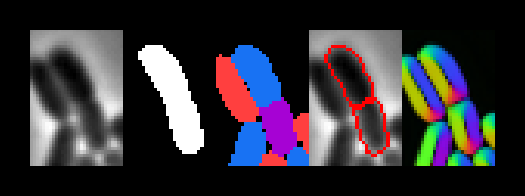

1


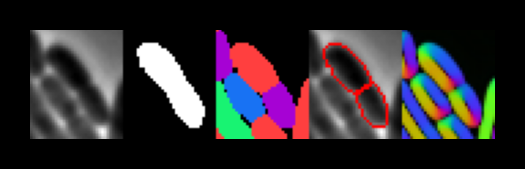

1


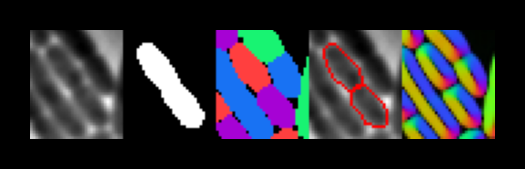

1


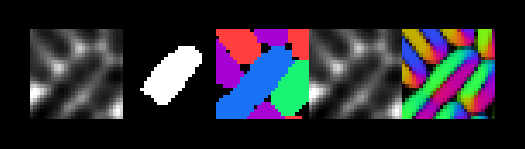

1


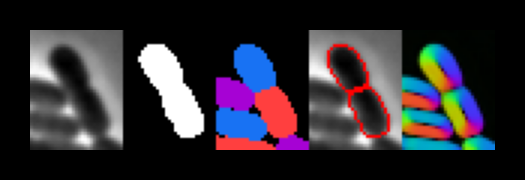

1


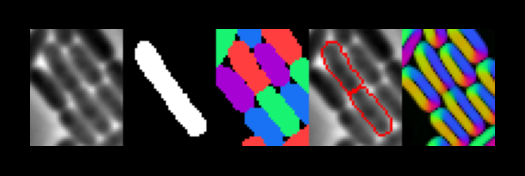

1


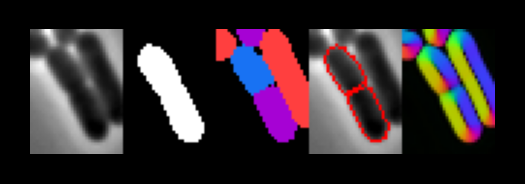

1


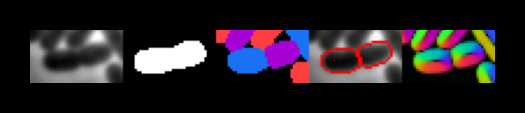

In [29]:
#code developing the error ideas 
ind = range(4)

from matplotlib.colors import ListedColormap
plt.style.use('dark_background')
# now find and crop specific cells for comparison 
# oversegmneted cells will have low IoUs spread out over several hits; let's take a specific image from the rpevious list as an example. We can see that there are three true labels, but 
# several predicted labels. The IoU can be at most 1, but small precited labels will always be quite small, up to 1/(area of the true label). But we don't really want to care about the 
cm2 = ListedColormap([color for color in sinebow(5).values()])

k = 3
j = 2 # look at Omnipose

m = 0
r_pred = OvR[j][k].copy()
mx = np.max(r_pred,axis=0) 
# std = np.std(r_pred,axis=0)
mx[mx==0] = np.nan
hits_pred = r_pred==mx
err = np.abs(np.sum(hits_pred,axis=1)-1)



# err = cell_errors[j][k]# assuming proper precomputing 
areas = cell_areas[k]
error_cutoff = 1
area_cutoff = 10
err_indexes = np.nonzero(np.logical_and(err>=error_cutoff,areas>area_cutoff))[0]

pad = 5

for l in err_indexes[0:10]:
    print(err[l])
    mgt = masks_gt_clean[k]
    y,x = np.nonzero(mgt==l+1)
    max_y,max_x = np.array(mgt.shape)-1
    
    y0 = max(0,min(y)-pad)
    y1 = min(max_y,max(y)+pad)
    x0 = max(0,min(x)-pad)
    x1 = min(max_x,max(x)+pad)
    
    p = transforms.normalize99(imgs[k][y0:y1,x0:x1],omni=True)

    mask_gt = mgt[y0:y1,x0:x1]
    bini = mask_gt==l+1
    img0 = np.stack((p,p,p),axis=2)
    outli = transforms.normalize99(plot.outline_view(img0*255,bini),omni=True)
    bin0 = np.stack((bini,bini,bini),axis=2)
    gt_pic = np.hstack((img0,outli,bin0))
    mask_pred = masks[j][k][y0:y1,x0:x1]
    flow_pred = transforms.normalize99(flows[j][k][y0:y1,x0:x1],omni=True)
    
    inds = np.where(hits_pred[l,:])
    rmask = np.zeros_like(mask_gt)
    for i,label in enumerate(inds[0]):
        rmask[mask_pred==label+1] = i+1

    outl_pred = transforms.normalize99(plot.outline_view(img0,rmask),omni=True)
    res_pred = np.hstack((img0,bin0,cm2(ncolorlabel(mask_pred))[:,:,:3],outl_pred,flow_pred))
    plt.figure(figsize=[2,2])
    plt.imshow(res_pred)
    plt.axis('off')
    plt.show()

# Figure 2A
For this plot, I should put both the training and test errors. The training dataset has a lot more long cells in it. In fact, I should do the analysis with the train, test, and combined to show correlation and lack of overfitting. 

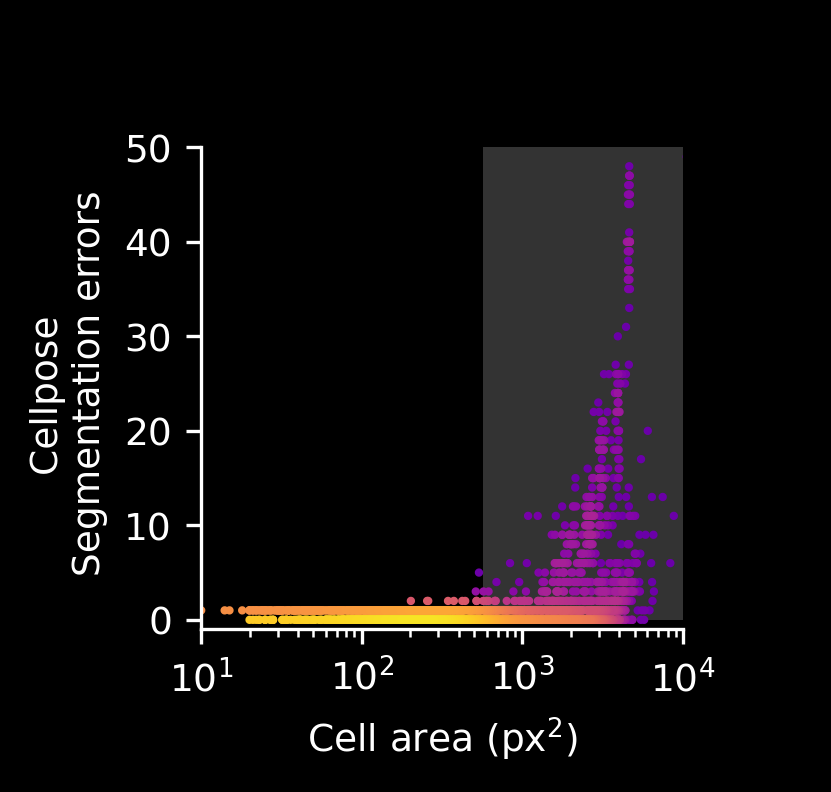

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches
from scipy.stats import gaussian_kde
import cmasher as cmr
from cellpose.omnipose.utils import ncolorlabel

color = [1,0,0,.5]
axcol = 'k'

# some random data
# x = np.random.randn(1000)
# y = np.random.randn(1000)
j = 0 # which algorithm
x = np.concatenate(cell_areas)
y = np.concatenate(cell_errors[j])
xmin = 10
xmax = 10**4
# cm = plt.cm.get_cmap('plasma')
cm = cmr.get_sub_cmap('plasma', 0.2, 0.95)

def scatter_hist(x, y, ax, ax_histx, ax_histy,zorder=1, hist = 1):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
#     ax.scatter(x, y, s=3,edgecolors='none',c=color)
    
#         y = np.array(ap[j]).T.flatten()
#         X = np.repeat(x,len(ap[j][0]))
    X = x.copy()
    xy = np.vstack([X,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    X, y, z = X[idx], y[idx], z[idx]
    ax.scatter(X, y, c=np.log(z), s=1,cmap=cm,zorder=zorder)
    
    
    if hist:
        # now determine limits by hand:
        binwidth1 = 100
        binwidth2 = 1
        eps = 1e-20
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth1) + 1) * binwidth1
        pp = 1
        bins1 = np.arange(xmin, lim + binwidth1, binwidth1)
        bins2 = np.arange(0, 55 + binwidth2, binwidth2)
        logbins1 = np.logspace(np.log10(bins1[0]),np.log10(bins1[-1]),len(bins1))

        # plot histogram
        n,bins,patches = ax_histx.hist(x, bins=logbins1,color=color)
        col = (n-n.min())/(n.max()-n.min())+eps
        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c**pp))

        n,bins,patches = ax_histy.hist(y, bins=bins2, orientation='horizontal',color=color,align='left')
        col = (n-n.min())/(n.max()-n.min())+eps
        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c**.25))
    
    
#     ax_histx.tick_params(axis='x',which='both',bottom=False,top=False)
#     ax_histy.tick_params(axis='y',which='both',left=False,right=False)
#     ax_histy.get_xaxis().set_ticks([])
#     ax_histy.get_yaxis().set_ticks([])
    

#     plt.xlim([0,10**3])
# start with a square Figure
# a = 1+golden
a = 5
b = 1
c = 2.5
labelsize = 9
fig = plt.figure(figsize=(c, c))


# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.

gs = fig.add_gridspec(2, 2,  width_ratios=(a, b), height_ratios=(b, a),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.075, hspace=0.075)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.xscale('log')
# plt.yscale('log')
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# plt.xscale('log')
x0 = np.percentile(x,75)
x1 = np.max(x)
y1 = np.max(y)
ax.add_patch(
     patches.Rectangle(
        (x0, 0),
        x1-x0,
        50,
        edgecolor = None,
        facecolor = [.2]*3,
        fill=True,
        zorder=1
     ))
# ax.vlines(x0,0,y1,colors=[.5]*4,linestyles='dashed',linewidth=1)
# use the previously defined function to do scatter plot
scatter_hist(x, y, ax, ax_histx, ax_histy,zorder=2, hist=0)
plt.xscale('log')
ax.set_ylabel(names[j]+' \n Segmentation errors', fontsize = labelsize)
ax.set_xlabel('Cell area (px$^2$)', fontsize = labelsize)
ax.set_ylim(-1,50)
ax.set_xlim(1e1,1e4)
ax.patch.set_alpha(0.0)

fig.patch.set_facecolor(background_color)

x_major = mpl.ticker.LogLocator(base = 10.0, numticks = 10)
ax.xaxis.set_major_locator(x_major)
x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.yticks(range(y0,y1,10))

ax.tick_params(axis='both', which='major', labelsize=labelsize)

# x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 10)
# ax_histy.yaxis.set_major_locator(x_major)
# x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
# ax_histy.yaxis.set_minor_locator(x_minor)
# ax_histy.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax_histy.axis('off')
ax_histx.axis('off')

# ax_histy.spines['right'].set_visible(False)
# ax_histy.spines['top'].set_visible(False)
# ax_histy.spines['bottom'].set_visible(False)
# ax_histy.spines['left'].set_visible(False)
# ax_histy.get_xaxis().set_ticks([])
# ax_histy.get_yaxis().set_ticks([])
# ax_histy.get_yaxis().set_visible(False)
# plt.xlim([xmin,xmax])
plt.show()

# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/errors_vs_area_hist'+suffix+'.eps',bbox_inches='tight',transparent=True,pad_inches=0)
fig.savefig('/home/kcutler/DataDrive/omnipose_paper/errors_vs_area_hist'+suffix+'_'+names[j]+'.pdf',bbox_inches='tight')
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/errors_vs_area_hist.png',bbox_inches='tight')

## Calculate probability of errors above and below cutoff

In [38]:
m = np.percentile(x,75)
print('Top quartile of area is', m)
for j in [2,1,0]:
    y = np.concatenate(cell_errors[j])
    r = x*y
    p = y>0
    q = np.logical_and(x>=m,p)
    s = np.logical_and(x<m,p)
    print(names[j])
    print('probability of having one error after cutoff:',np.count_nonzero(q)/np.count_nonzero(x>=m)*100)
    print('probability of having one error under cutoff:',np.count_nonzero(s)/np.count_nonzero(x<m)*100)
    print('probability of having one error:',np.count_nonzero(y)/np.count_nonzero(x)*100)


Top quartile of area is 571.0
Omnipose
probability of having one error after cutoff: 4.151813797441812
probability of having one error under cutoff: 3.521422570708485
probability of having one error: 3.6792106229990025
Mixed
probability of having one error after cutoff: 9.540784231495072
probability of having one error under cutoff: 8.996079529543545
probability of having one error: 9.1324200913242
Cellpose
probability of having one error after cutoff: 17.739568043615016
probability of having one error under cutoff: 7.826939232707924
probability of having one error: 10.308087965149845


## Select examples of errored cells

In [40]:
import os
from scipy.ndimage.morphology import binary_erosion, binary_dilation
from cellpose import utils, transforms
from cellpose.omnipose.utils import ncolorlabel, sinebow
import cv2
from cellpose.io import imsave
from PIL import Image, ImageFont, ImageDraw, ImageOps
from matplotlib.colors import ListedColormap
import os, datetime, gc, warnings, glob



plt.style.use('dark_background')
cmap = mpl.cm.get_cmap('viridis')
cm2 = ListedColormap([color for color in sinebow(5).values()])
cm3 = ListedColormap([color for color in sinebow(5,bg_color=[1,1,1,1]).values()])

basedir = '/home/kcutler/DataDrive/omnipose_paper/Comparison Examples/newcompare3/'
if not os.path.isdir(basedir):
    os.mkdir(basedir)

area_cutoff = 20
error_cutoff=2
pad = 10
N = len(masks)
nimg = len(masks_gt)
bkct = 500
bg = 0.5
ext = '.png'

cnt = 0
txtpad = 10
yoffset = [0,0]

img_list = ['ftsN_ensemble_0','caulo_15','streptomyces_XY15_1','Az_branch_ec_0','Hpylori2_2',
            'PSVB_ensemble_c_8','PSVB_ensemble_c_5','PSVB_ensemble_c_2','PSVB_ensemble_c_0','PSVB_ensemble_c_12','PSVB_ensemble_c_11','PSVB_ensemble_c_10',
            'vibrio_ensemble_2_19','wiggins_ensemble_1','wiggins_ensemble_11']

# cells were chosen by using the Matlotlib Widget and hovering over cells that I wanted to extract to get the ground truth index 
# e.g. plt.imshow(masks_gt_clean[img_index[6]])
cell_list = [10,8,None,33,44,
             160,193,31,58,12,49,10,#[180,194,201]
             None,399,119]# [370,399]

namelist = [os.path.splitext(os.path.split(file)[-1])[0] for file in img_names]
img_index = [namelist.index(im) for im in img_list]
[print(l,k) for l,k in zip(cell_list,img_index)]

n_exmpl = len(img_list)
label_list = []*n_exmpl
coords = []*n_exmpl

for j in [0]: #base selection on cellpose examples
    for l,k in zip(cell_list,img_index): # replace loops over k and l 
        
        file = img_names[k]
        basename = os.path.splitext(os.path.split(file)[-1])[0]

        mgt = masks_gt_clean[k]
        p = transforms.normalize99(imgs[k],omni=True)
        img0 = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(mgt==0)])))

        if l is not None:
            if isinstance(l, list):
                hits = np.any(np.stack(([mgt==li+1 for li in l])),axis=0)
            else:
                hits = mgt==l+1
            
            microcolonies = mgt>0
            labels = skimage.measure.label(microcolonies)
            binmask = hits.copy()
            for cell_ID in np.unique(labels[labels>0]):
                mask = labels==cell_ID 
                area = np.count_nonzero(mask)
                overlap = np.count_nonzero(np.logical_and(mask, binary_dilation(hits, iterations=1)))
                if overlap > 0: #only premove cells that are 50% or more edge px
                    binmask[mask] = 1

            y,x = np.nonzero(binmask)
            max_y,max_x = np.array(mgt.shape)-1

            y0 = max(0,min(y)-pad)
            y1 = min(max_y,max(y)+pad)
            x0 = max(0,min(x)-pad)
            x1 = min(max_x,max(x)+pad)

            # p = img0[y0:y1,x0:x1]
            # mask_gt = mgt[y0:y1,x0:x1]
            xy = [y0,y1,x0,x1]
        else:
            ly,lx = mgt.shape
            xy = [0,ly,0,lx]
        
        coords.append(xy)


10 56
8 30
None 99
33 41
44 83
160 20
193 17
31 14
58 12
12 24
49 23
10 22
None 103
399 104
119 109


In [41]:
# re-run both models on full images to reproduce the exact reults from main code
# (Crop later; cropped images can have slight significant differences in results for veery small crops). 
chans = [0,0] 
names = ['Cellpose','OmniSeg']
suffixes = ['_CP','_OM']
imglist = [imgs[k] for k in img_index]
J = len(names)
nimg = len(imgs)
masks,flows,styles,d = [[]]*J,[[]]*J,[[]]*J,[[]]*J
for j in range(J):
    masks[j], flows[j], styles[j], = model[j].eval(imglist,channels=[0,0],mask_threshold=-1,diameter=0,cluster=j,
                                                   flow_threshold=0,omni=j, calc_trace=True, min_size=0,tile=False,transparency=True)


2021-11-16 18:16:07,145 [INFO] 0%|          | 0/15 [00:00<?, ?it/s]


/home/kcutler/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-11-16 18:16:53,315 [INFO] 100%|##########| 15/15 [00:23<00:00,  1.58s/it]


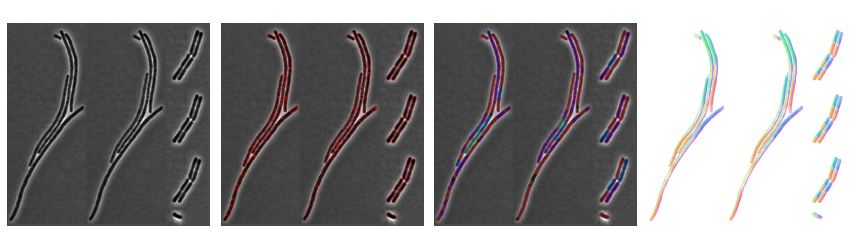

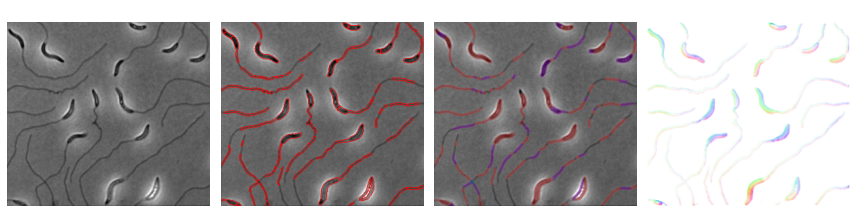

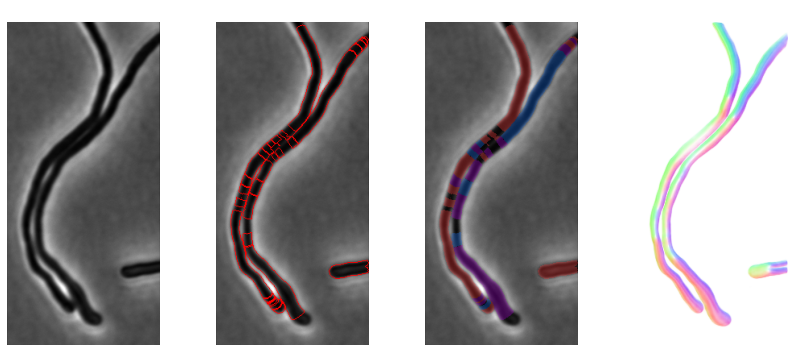

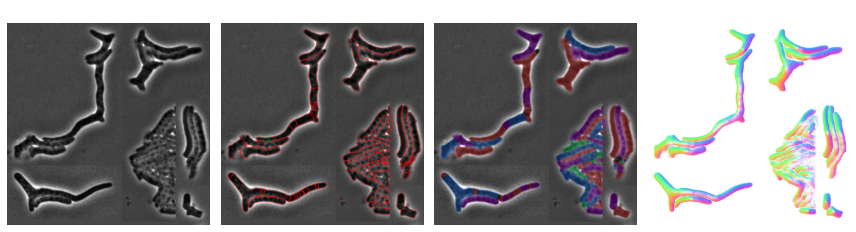

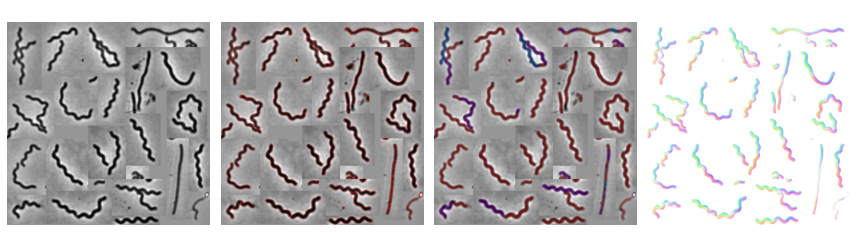

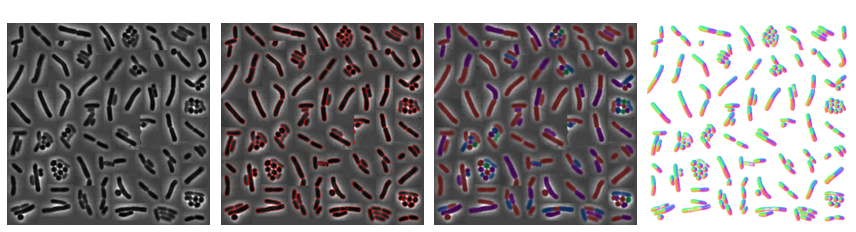

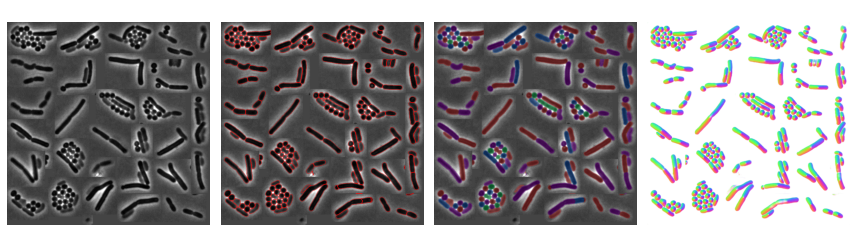

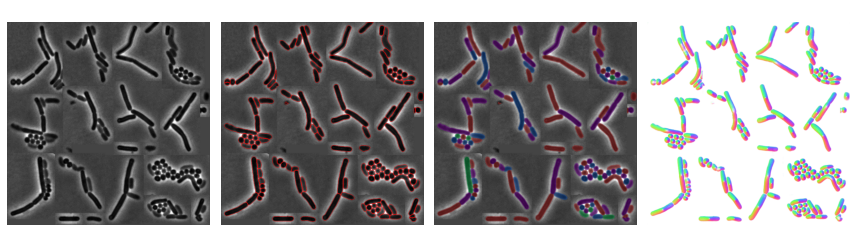

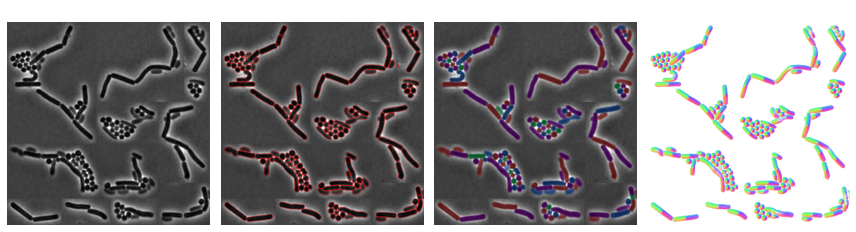

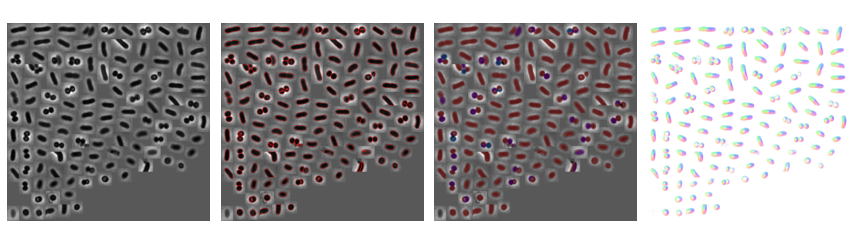

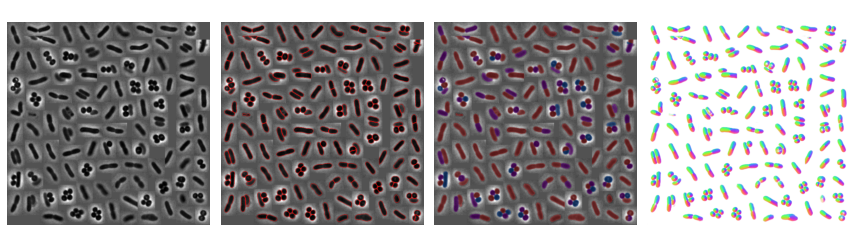

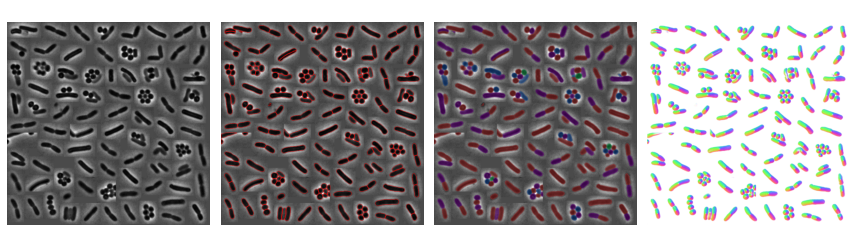

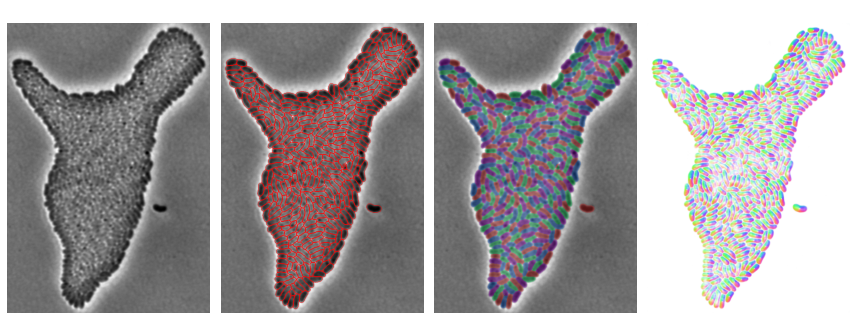

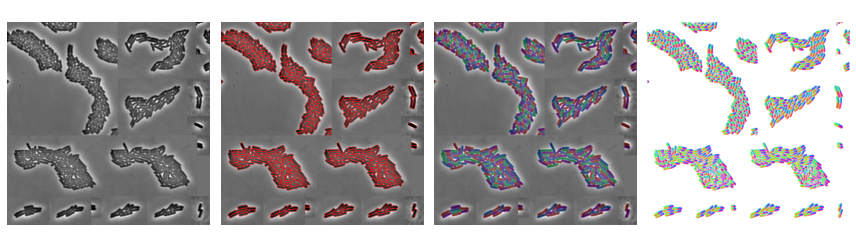

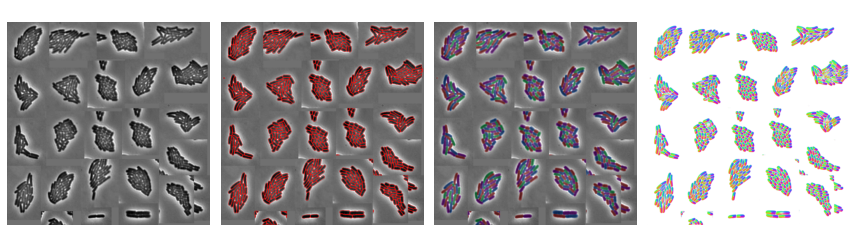

In [42]:
# show the results
%matplotlib inline
from cellpose import plot
j = 0
nimg = len(imgs)
for idx,im in enumerate(imglist):
    maski = masks[j][idx]
    flowi = flows[j][idx][0]
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, im, maski, flowi, channels=chans, omni=True, bg_color=0)
    plt.tight_layout()
    plt.show()

# Figure 2B

_CP False


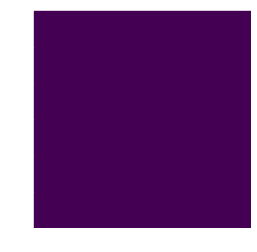

transposing
/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_CP
_OM True


/tmp/ipykernel_715691/2542847667.py:110: UserWarning: /home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/boundary_CP.png is a low contrast image
  skimage.io.imsave(os.path.join(savedir,'boundary'+suffix+ext),((pic)*255).astype(np.uint8))


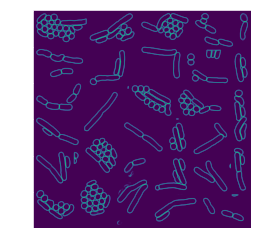

transposing
/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


In [120]:
import edt
from matplotlib import rc
from cellpose.omnipose import utils
import cmasher as cmr
from skimage import filters
darkmode=1

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline
A = 1
px = A/plt.rcParams['figure.dpi']  # pixel in inches
# cmap = mpl.cm.get_cmap('plasma')
cmap = cmr.get_sub_cmap('plasma', 0, 0.95)
cmap2 = cmr.get_sub_cmap('gray', 0, 1)


do_flows = 0
isolated = 0

basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison'
io.check_dir(basedir)
for j in range(J): # select from models
# for j in [-1]:
    suffix = suffixes[j]
    omni = 'OM' in suffix
    print(suffix,omni)
    # for k in range(n_exmpl): # select from images 
    # for k in [4]:
    for k in [6]: # limit to this particular cell 
    
        xy = coords[k].copy() # for cropping
        ly,lx = xy[1]-xy[0],xy[3]-xy[2]
        
        # outline thickness
        if px*lx<2:
            mode = 'inner'
        else:
            mode = 'thick'
        
        mgt = masks_gt[img_index[k]].copy()
        p = transforms.normalize99(imglist[k],omni=True)
        img0 = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(mgt==0)])))
        
        mpred = masks[j][k].copy()
        dP_pred = flows[j][k][1].copy()
        cellprob = flows[j][k][2].copy()
        bd = flows[j][k][3].copy() if omni else np.zeros_like(cellprob)
        bd = 1/(1+np.exp(-bd))
        plt.imshow(utils.rescale(bd))
        plt.show()
        tr = flows[j][k][-1][0].copy()

        # make veritcal
        if ly<lx:
            print('transposing')
            mgt = np.transpose(mgt)
            img0 =  np.transpose(img0)
            dP_pred = np.transpose(dP_pred,(0,2,1))
            #traspose
            v1 =  dP_pred[1].copy()
            v2 =  dP_pred[0].copy()
            theta = 90
            dP_pred[0] = (-v1 * np.sin(-theta) + v2*np.cos(-theta))
            dP_pred[1] = -(v1 * np.cos(-theta) + v2*np.sin(-theta))
            tr = np.stack((tr[1],tr[0]))
            cellprob = np.transpose(cellprob)
            bd = np.transpose(bd)
            mpred = np.transpose(mpred)
            xy = [xy[2],xy[3],xy[0],xy[1]]
        
        #crop
        mpred_full = mpred.copy()
        mpred = mpred[xy[0]:xy[1],xy[2]:xy[3]]
        mgt = mgt[xy[0]:xy[1],xy[2]:xy[3]]
        cellprob = cellprob[xy[0]:xy[1],xy[2]:xy[3]]
        bd = bd[xy[0]:xy[1],xy[2]:xy[3]]
        dP_pred = dP_pred[:,xy[0]:xy[1],xy[2]:xy[3]]
        img0 = img0[xy[0]:xy[1],xy[2]:xy[3]]
        
        match = np.argwhere([np.logical_and.reduce((xy[3]>=tr[1,i,0],xy[2]<=tr[1,i,0],xy[0]<=tr[0,i,0],xy[1]>=tr[0,i,0])) for i in range(tr.shape[1])]).flatten()
        # tr = tr[:,match,:]
        tr = np.stack(([tr[0,i,:]-xy[0] for i in match],[tr[1,i,:]-xy[2] for i in match]))
        
        flow_pred = plot.dx_to_circ(dP_pred,transparency=True)
        l = cell_list[k] # cell label list
        
        bini = mgt>0
        bin0 = np.stack((bini,bini,bini),axis=2)
        
        savedir = os.path.join(basedir, img_list[k] + '_cell_number_'+ str(l))
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        path = os.path.join(savedir,'perim_flows' + suffix)
        print(path)
        
        skimage.io.imsave(os.path.join(savedir,'phase'+ext),np.uint8(img0*255))
        skimage.io.imsave(os.path.join(savedir,'flow'+suffix+ext),np.uint8(flow_pred*255))
        pic = cmap(utils.rescale(cellprob))
        pic[:,:,-1] = utils.rescale(cellprob)
        skimage.io.imsave(os.path.join(savedir,'cellprob'+suffix+ext),((pic)*255).astype(np.uint8))
        
        pic = cmap2(utils.normalize99(bd))
        pic[:,:,-1] = utils.rescale(bd)
        skimage.io.imsave(os.path.join(savedir,'boundary'+suffix+ext),((pic)*255).astype(np.uint8))
        
        mask_threshold = -1
        if omni:
            mask0 = filters.apply_hysteresis_threshold(cellprob, mask_threshold-1, mask_threshold)
        else:
            mask0 = cellprob>mask_threshold
        b = np.zeros_like(mask0)
        pic = np.stack((mask0,b,b),axis=-1)
        skimage.io.imsave(os.path.join(savedir,'cellprob_thresh'+suffix+ext),((pic)*255).astype(np.uint8))

        if isolated:
            mag = transforms.normalize99(np.sqrt(np.sum(dP_pred**2,axis=0)),omni=True)
            f = flow_pred.copy()
            flow_gray = 0.2125*f[:,:,0] + 0.7154*f[:,:,1] + 0.0721*f[:,:,2]
            m = bini==0
            f[m] = np.stack([flow_gray,flow_gray,flow_gray,mag],axis=-1)[m]
            skimage.io.imsave(os.path.join(savedir,'flow_gray'+suffix+ext),np.uint8(f*255))
        
#         ncolor_gt = utils.ncolorlabel(mgt)
        m = mgt.copy()
        u = np.unique(mgt)
        U = len(u)
        A = 100
        v = [0]+list(np.linspace(.25,.55,U-1)*A)
        res = dict(zip(u, v))
        m = fastremap.remap(m,res,preserve_missing_labels=False, in_place=True)
        ncolor_gt = utils.rescale(utils.ncolorlabel(m.copy()))
        ncolor_gray = np.stack([utils.rescale(ncolor_gt)]*3,axis=-1)
        skimage.io.imsave(os.path.join(savedir,'ncolor_gray_masks'+ext),np.uint8(ncolor_gray*255))

        ncolor_gray = np.stack([1-ncolor_gt]*3,axis=-1)
        skimage.io.imsave(os.path.join(savedir,'ncolor_gray_masks_inv'+ext),np.uint8(ncolor_gray*255))
        
        ncolor_pred = utils.rescale(utils.ncolorlabel(mpred.copy()))
        skimage.io.imsave(os.path.join(savedir,'ncolor_pred'+ext),np.uint8(ncolor_pred*255))
        

        outli = plot.outline_view(img0,mpred,color=cmap(.85)[:3],mode=mode)
        skimage.io.imsave(os.path.join(savedir,'outline_view_gold'+suffix+ext),np.uint8(outli*255))
        outli = plot.outline_view(img0,mpred,mode=mode)
        skimage.io.imsave(os.path.join(savedir,'outline_view_red'+suffix+ext),np.uint8(outli*255))
       
        mgt, remap = fastremap.renumber(mgt)
        iou = metrics._intersection_over_union(mgt, mpred)
        th = 0
        n_min = min(iou.shape[0], iou.shape[1])
        costs = -(iou >= th).astype(float) - iou / (2*n_min)
        true_ind, pred_ind = linear_sum_assignment(costs)
        miou = iou[true_ind, pred_ind]

        # print('match',miou,pred_ind,mask_match,pred_inds,true_ind)
        with open(os.path.join(savedir,'MMiou'+suffix+'.txt'), "w") as text_file:
            print(f"Mean Matched IoU: {np.mean(miou)}", file=text_file)
                               
        if do_flows:
            dists = edt.edt(mpred)
            bd = dists==1
            
            Y,X = np.nonzero(bd)
            # Y = Y[np.logical_and(Y>=xy[0],Y<=xy[1])]
            # X = X[np.logical_and(X>=xy[2],X<=xy[3])]
            a = .5
            match0 = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
            select_inds = np.argwhere(match0).flatten()
            
            Y,X = np.nonzero(mpred)
            # Y = Y[np.logical_or(Y>=xy[0],Y<=xy[1])]
            # X = X[np.logical_or(X>=xy[2],X<=xy[3])]
            a = .5
            match2 = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
            select_inds2 = np.argwhere(match2).flatten()

            lx = mpred.shape[1]
            ly = mpred.shape[0]

            fig,ax = plt.subplots(figsize=(ly*px,lx*px))
            # ax.imshow(dists)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_position([0, 0, 1, 1])
            
            for i in select_inds:
                xs = tr[1,i,:]
                ys = tr[0,i,:]
                if darkmode:
                    c = [1,1,1,.5]
                    s2 = '_darkmode'
                else:
                    c = [0,0,0,.25]
                    s2 = '_lightmode'
                ax.plot(xs,ys,c=c,solid_capstyle='round',linewidth=1/2,zorder=1)
                
            for i in select_inds2:
                ax.scatter(tr[1,i,-1],tr[0,i,-1],marker='.',s=px*lx,edgecolor=None,facecolor='r',zorder=2)
            
            ax.set_xlim([0,lx])
            ax.set_ylim([ly,0])
            ax.patch.set_alpha(0.)
            fig.patch.set_facecolor(None)

            plt.show()
            
            fig.savefig(path+s2+'.pdf',bbox_inches='tight',transparent=True,pad_inches=0)
            fig.savefig(path+s2+'.png',bbox_inches='tight',transparent=True,pad_inches=0,dpi=1000)
        

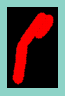

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


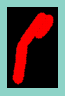

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


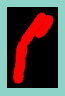

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


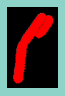

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


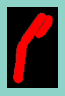

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


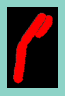

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


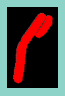

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


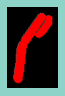

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


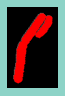

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


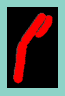

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


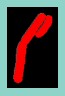

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


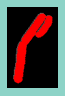

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


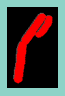

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


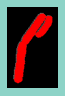

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


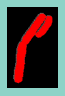

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


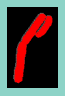

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


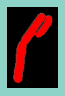

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


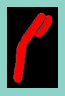

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


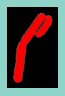

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


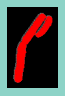

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


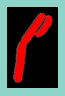

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


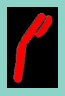

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


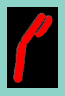

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


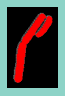

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


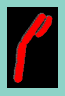

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


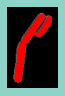

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


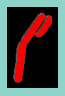

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


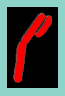

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


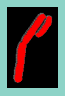

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


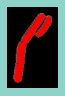

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


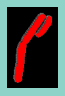

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


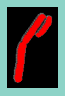

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


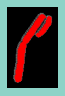

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


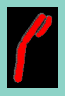

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


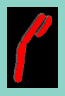

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


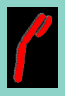

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


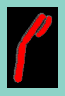

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


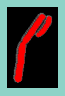

/home/kcutler/DataDrive/omnipose_paper/Figure 2/comparison/PSVB_ensemble_c_5_cell_number_193/perim_flows_OM


In [119]:
# for t in range(0,tr.shape[-1],10):
# for t in range(0,10):
T = np.geomspace(1,tr.shape[-1],50)
t = [round(t)-1 for t in T]
T = np.unique(t)
for t in T:

    dists = edt.edt(mpred)
    bd = dists==1

    Y,X = np.nonzero(bd)
    # Y = Y[np.logical_and(Y>=xy[0],Y<=xy[1])]
    # X = X[np.logical_and(X>=xy[2],X<=xy[3])]
    # extract boundary points for trajectory plotting
    a = .5
    match0 = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
    select_inds = np.argwhere(match0).flatten()

    Y,X = np.nonzero(mpred)
    # Y = Y[np.logical_or(Y>=xy[0],Y<=xy[1])]
    # X = X[np.logical_or(X>=xy[2],X<=xy[3])]
    # extract cell poitns for final point plotting 
    a = .5
    match2 = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
    select_inds2 = np.argwhere(match2).flatten()

    lx = mpred.shape[1]
    ly = mpred.shape[0]

    fig,ax = plt.subplots(figsize=(ly*px,lx*px))
    ax.imshow(np.zeros_like(dists),cmap='gray')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_position([0, 0, 1, 1])

    for i in select_inds:
        xs = tr[1,i,:]
        ys = tr[0,i,:]
        if darkmode:
            c = [1,1,1,.5]
            s2 = '_darkmode'
        else:
            c = [0,0,0,.25]
            s2 = '_lightmode'
        ax.plot(xs,ys,c=c,solid_capstyle='round',linewidth=1/2,zorder=1)

    for i in select_inds2:
        ax.scatter(tr[1,i,t],tr[0,i,t],marker='.',s=px*lx,edgecolor=None,facecolor='r',zorder=2,rasterized=True)

    ax.set_xlim([0,lx])
    ax.set_ylim([ly,0])
    ax.patch.set_alpha(0.)
    fig.patch.set_facecolor(None)

    plt.show()
    
    
    savedir = os.path.join(basedir, img_list[k] + '_cell_number_'+ str(l))
    io.check_dir(savedir)
    path = os.path.join(savedir,'perim_flows' + suffix)
    io.check_dir(path)
    print(path)
    
    # fig.savefig( os.path.join(path,'t'+str(t)+s2+'.pdf'),bbox_inches='tight',transparent=True,pad_inches=0)
    fig.savefig( os.path.join(path,'%03d'%t+s2+'.png'),bbox_inches='tight',transparent=True,pad_inches=0,dpi=1000)

In [118]:
# plt.plot(np.geomspace(1,100,50))
T = np.geomspace(1,tr.shape[-1],50)
t = [round(t)-1 for t in T]
T = np.unique(t)
T

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        14,  16,  18,  20,  22,  25,  28,  31,  35,  39,  43,  48,  54,
        60,  67,  75,  84,  93, 104, 116, 129, 144, 161, 179, 200])

## Export Error examples
From cell errors we can look at tons of examples. My current code just gives every single instance of an error. We see from the above histogram that my Omnipose barely gives any errors above 1 (these are issues with cell division, I think). 

- Enforce a minimum crop size 
- Sort by number of errors 
- Dump images into a PDF with info 

In [ ]:
import os
from scipy.ndimage.morphology import binary_erosion 
from cellpose import utils, transforms, plot
import cv2
from cellpose.io import imsave
from PIL import Image, ImageFont, ImageDraw, ImageOps
from matplotlib.colors import ListedColormap
import os, datetime, gc, warnings, glob
from fpdf import FPDF

plt.style.use('dark_background')
cmap = mpl.cm.get_cmap('viridis')
cm2 = ListedColormap([color for color in sinebow(5).values()])

basedir = '/home/kcutler/DataDrive/omnipose_paper/Comparison Examples/Per_Cell_GT_Comparison/'
io.check_dir(basedir)
    
cutoff=1
pad = 10
N = len(masks)
nimg = len(masks_gt)
bkct = 500
bg = 0.5


txtpad = 10
yoffset = [0,0]
buffer = 30
do_pdf = 0
clean = 1
# for k in range(nimg):
# for k in [0]:
for j in [0]:
    if do_pdf:
        pdf = FPDF(unit='pt')
        pdf.add_page()
        pdf.set_font('Arial', 'B', 8)
        pdf.set_text_color(r=255, g=255, b=255)
        pdf.set_fill_color(0,0,0)
        ph = pdf.h
        pw = pdf.w
        pdf.page_break_trigger = ph
        pdf.rect(0,0,pw,ph,'F')
        pdf.set_xy(0,0)
        ind = 0
        cnt = 0
    
    
    for k in range(nimg):
#     for k in range(50):
        file = img_names[k]
        basename = os.path.splitext(os.path.split(file)[-1])[0]

        label_list = []
        err = cell_errors[j][k]      
        err_indexes = np.nonzero(err>=cutoff)[0]
        num_errors = err_indexes.size
        if num_errors > 0:
            
            for l in err_indexes:
                name = basename + '_' + names[j] + '_cell_number_'+ str(l) + '.png'
                savepath = os.path.join(basedir, name)
                print(j,k,l,name)
                
                if not os.path.isfile(savepath) or clean: 
                    mgt = masks_gt_clean[k]
                    p = transforms.normalize99(imgs[k],omni=True)
                    img0 = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(mgt==0)])))

                    y,x = np.nonzero(mgt==l+1)
                    max_y,max_x = np.array(mgt.shape)-1

                    y0 = max(0,min(y)-pad)
                    y1 = min(max_y,max(y)+pad)
                    x0 = max(0,min(x)-pad)
                    x1 = min(max_x,max(x)+pad)

                    p = img0[y0:y1,x0:x1]

                    pic = [[]]*2
                    img0 = np.stack((p,p,p),axis=2)
                    maski = masks[j][k][y0:y1,x0:x1]
                    flowi = transforms.normalize99(flows[j][k][y0:y1,x0:x1],omni=True)
                    outli = transforms.normalize99(plot.outline_view(img0,maski),omni=True)
                    pic[0] = np.hstack((img0,outli,flowi))

                    maski = mgt[y0:y1,x0:x1]
    #                 print(np.unique(maski),l)
                    bini = maski==l+1
                    bini = np.stack((bini,bini,bini),axis=2)
                    outli = transforms.normalize99(plot.outline_view(img0,maski),omni=True)
                    pic[1] = np.hstack((cm2(utils.ncolorlabel(maski))[:,:,:3],outli,bini))

                    img = np.vstack((pic[0],pic[-1]))
                
                    io.imsave(savepath,np.uint8(img*255))
                
                if do_pdf:
                    im = Image.open(savepath)
                    y = pdf.get_y()

                    h = ((pw/2)/im.size[0])*im.size[1]
                    if yoffset[ind]+h+txtpad+buffer>=ph:
                        pdf.add_page()
                        pdf.rect(0,0,pw,ph,'F')
                        pdf.set_xy(0,0)
                        yoffset = [0,0]
                        ind = 0
                        pdf.set_xy(0,0)
                        cnt = 0
                    elif cnt==0 or cnt==1:
                        pdf.set_xy(ind*pw/2,yoffset[ind])
                    else:
                        pdf.set_xy(ind*pw/2,yoffset[ind]+txtpad)

                    if h<ph:
                        pdf.image(savepath,w=pw/2)
                    else:
                        pdf.image(savepath,h=ph-2*txtpad)
                    pdf.cell(30, 10, txt=name)
    #                 pdf.cell(30, 10, txt=str(j)+','+str(k)+','+str(l))
    #                 pdf.cell(30, txtpad, str(ind))
    #                 print(ind,yoffset)
                    yoffset[ind] = pdf.get_y()
                    ind = (ind+1)%2
                    cnt += 1
    if do_pdf:         
        pdf.output('/home/kcutler/DataDrive/'+names[j]+'_errors.pdf','F')
                
